# KM3NeT

In [1]:
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
import re
import mysql.connector
import pymysql

Definimos la estructura de datos

In [71]:
def procesar_paquete_v3(paquete):
    data = {}
    try:
        data["Data_Type"] = int(paquete[0:8],16)
        data["RunNumber"] = int(paquete[8:16],16)
        data["UDP_Sequence_Number"] = int(paquete[16:24],16)
        data["Timestamp_Gross_s"] = int(paquete[24:32],16)
        data["Timestamp_Tick_16ns"] = int(paquete[32:40],16)
        data["DOM_ID"] = int(paquete[40:48],16)
        data["Status_I"] = int(paquete[48:56],16)
        data["Status_II"] = int(paquete[56:64],16) 
        data["Status_III"] = int(paquete[64:72],16) 
        data["Status_IV"] = int(paquete[72:80],16) 
    except ValueError:
        data = {
            "Data_Type": None,
            "RunNumber": None,
            "UDP_Sequence_Number": None,
            "Timestamp_Gross_s": None,
            "Timestamp_Tick_16ns": None,
            "DOM_ID": None,
            "Status_I": None,
            "Status_II": None,
            "Status_III": None,
            "Status_IV": None
        }

        return data
    return data

Procesamos cada paquete y lo enviamos a la base de datos

In [75]:
conn = mysql.connector.connect(user='root', password='012345', host='127.0.0.1', database='km3net')
cursor = conn.cursor()
with open("D_ORCA006_4_DOMs_0_NB_LOW_2_NB_HIGH_2021-10-22_sk.dmp", "rb") as archivo:
    cabecera = archivo.read(8982)
    while True:
        paquete_completo = archivo.read(100000)
        if not paquete_completo:
            break
        paquete_hex = paquete_completo.hex(" ")
        paquete_replace = paquete_hex.replace(" ","")
        start = 0
        end = 8
        while start < len(paquete_replace):
            chunk = paquete_replace[start:end]
            if chunk == "54544443":
                paquete = paquete_replace[start:start+80]
                if paquete:
                    data = procesar_paquete_v3(paquete)
                    if data is not None:
                        sql = "INSERT INTO datos (Data_Type, RunNumber, UDP_Sequence_Number, Timestamp_Gross_s, Timestamp_Tick_16ns, DOM_ID, Status_I, Status_II, Status_III, Status_IV) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
                        val = (data["Data_Type"], data["RunNumber"], data["UDP_Sequence_Number"], data["Timestamp_Gross_s"], data["Timestamp_Tick_16ns"], data["DOM_ID"], data["Status_I"], data["Status_II"], data["Status_III"],data["Status_IV"])
                        cursor.execute(sql, val)
                        conn.commit()
                    
            start += 8
            end += 8
conn.close()

Ahora podemos escoger los datos de un mismo DOM_ID

In [76]:
conn = mysql.connector.connect(user='root',
                               password='012345',
                               host='127.0.0.1',
                               database='km3net')


cursor = conn.cursor()
cursor.execute("SELECT * FROM datos WHERE DOM_ID=808976377")
resultados = cursor.fetchall()
conn.close()

In [89]:
ts1 = []
for resultado in resultados:
    ts1.append(resultado[3])

In [90]:
ts2 = []
for resultado in resultados:
    ts2.append(resultado[4])

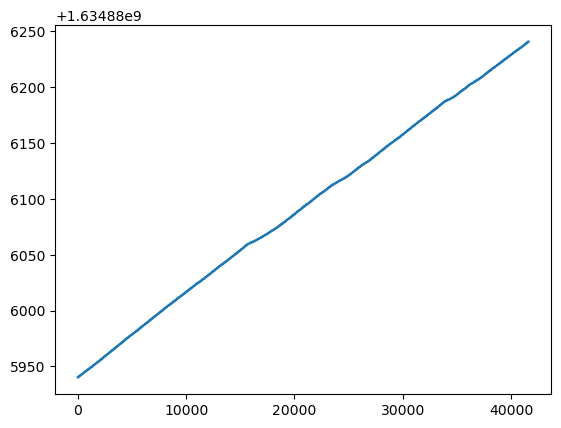

In [91]:
plt.plot(ts1)

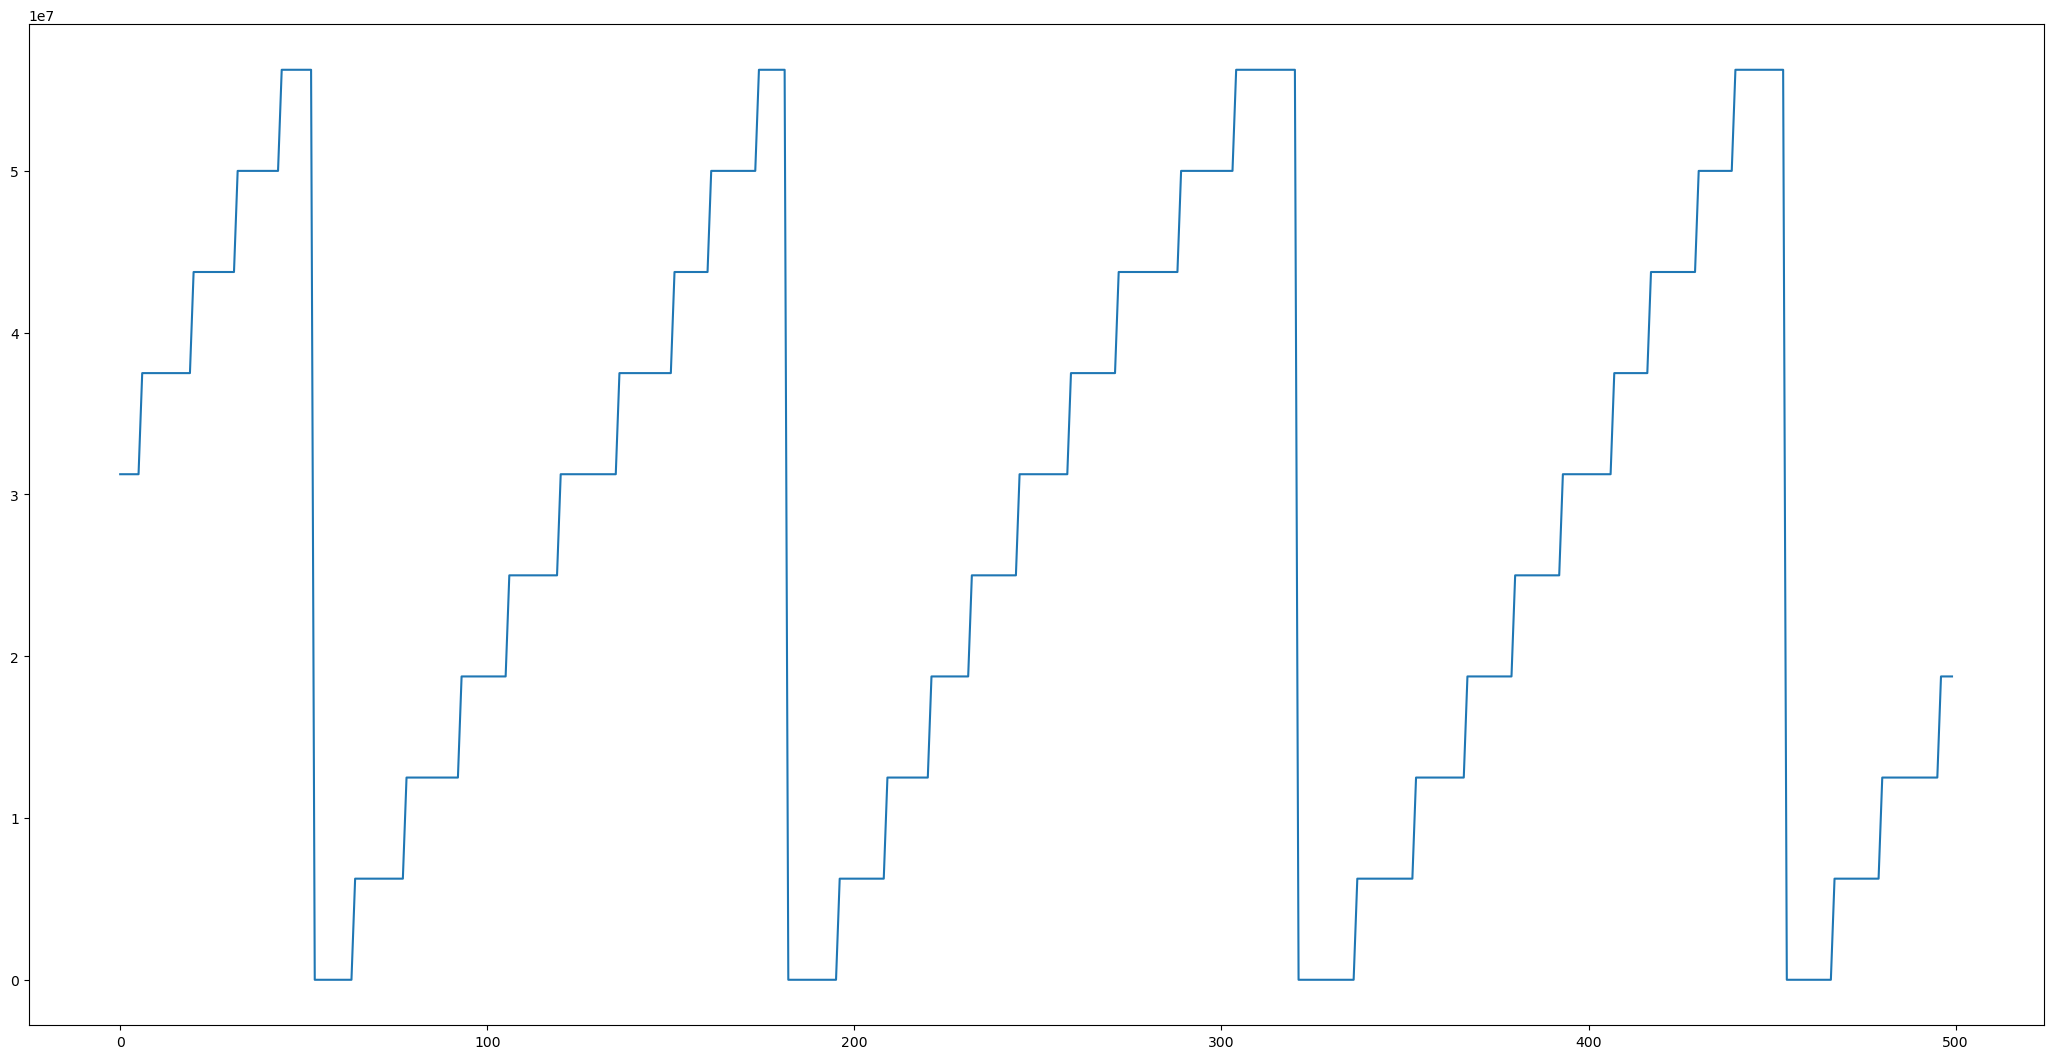

In [108]:
plt.figure(figsize=(26,13))
plt.plot(ts2[0:500])
plt.show()